In [11]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import re
import librosa.display
import seaborn as sns


def parse_diagnosis(info_file_path):
    """
    Parsuje diagnostickou informaci z textového souboru.

    Parametry:
    info_file_path : str
        Cesta k souboru obsahujícímu informace o diagnóze.

    Návratová hodnota:
    str : Diagnóza jako řetězec, pokud byla nalezena, jinak None.
    """
    with open(info_file_path, "r") as f:  # Otevření souboru pro čtení
        content = f.read()  # Načtení obsahu souboru

        # Hledání řádku obsahujícího "Diagnosis: " a následně diagnostický text
        diagnosis_match = re.search(r"Diagnosis:\s+(.+)", content)

        if diagnosis_match:
            return diagnosis_match.group(
                1
            ).strip()  # Vrácení extrahované diagnózy bez mezer

    return None  # Pokud diagnóza nebyla nalezena, vrátí None


# Funkce pro výpočet energie signálu
def compute_energy(signal):
    return np.abs(np.mean(signal**2))  # Oprava: použití absolutní hodnoty


# Funkce pro výpočet jitteru
def compute_jitter(signal, fs):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return len(zero_crossings) / len(signal)


# Cesta k adresáři se soubory hlasových záznamů
data_dir = "../data/voices"

# Seznam všech souborů v adresáři
dat_files = [f for f in os.listdir(data_dir) if f.endswith(".dat")]

# Seznam pro uložení výsledků
results = []
mfcc_variabilities = []  # Sbíráme hodnoty pro výpočet průměru

for dat_file in dat_files:
    file_path = os.path.join(data_dir, dat_file)
    info_file_path = os.path.join(data_dir, dat_file.replace(".dat", "-info.txt"))

    try:
        # Načtení signálu jako binárního souboru
        signal = np.fromfile(file_path, dtype=np.int16)
        fs = 8000  # Předpokládáme vzorkovací frekvenci 8000 Hz

        # Výpočet příznaků
        energy = compute_energy(signal)
        jitter = compute_jitter(signal, fs)
        mfccs = librosa.feature.mfcc(y=signal.astype(float), sr=fs, n_mfcc=13)
        mfcc_variability = np.std(mfccs)

        # Uložení hodnoty MFCC variability pro analýzu
        mfcc_variabilities.append(mfcc_variability)

        real_diagnosis = parse_diagnosis(info_file_path)

        results.append([dat_file, energy, jitter, mfcc_variability, real_diagnosis])

    except Exception as e:
        print(f"❌ Chyba při načítání {dat_file}: {e}")
        continue

# **Analýza datasetu**: Výpočet průměrné MFCC variability a odchylky
df = pd.DataFrame(
    results,
    columns=["Filename", "Energy", "Jitter", "MFCC Variability", "Real Diagnosis"],
)
mean_mfcc = df["MFCC Variability"].mean()
std_mfcc = df["MFCC Variability"].std()

# **Nové hranice na základě percentilů datasetu**
energy_threshold = np.percentile(df["Energy"], 25)  # Spodní 25. percentil
jitter_threshold = np.percentile(df["Jitter"], 75)  # Horní 75. percentil
mfcc_threshold = mean_mfcc + (std_mfcc * 0.8)  # Přísnější MFCC limit

print(f"📊 Průměrná MFCC variabilita: {mean_mfcc:.2f}")
print(f"📊 Směrodatná odchylka MFCC: {std_mfcc:.2f}")
print(f"📊 Energy threshold: {energy_threshold:.3f}")
print(f"📊 Jitter threshold: {jitter_threshold:.3f}")
print(f"📊 MFCC threshold: {mfcc_threshold:.3f}")


# **Přepočítání klasifikace** s novými hranicemi
def classify_voice(energy, jitter, mfcc_variability):
    if (
        energy < energy_threshold
        or jitter > jitter_threshold
        or mfcc_variability > mfcc_threshold
    ):
        return "Patologický"
    else:
        return "Dobrý"


df["Classification"] = df.apply(
    lambda row: classify_voice(row["Energy"], row["Jitter"], row["MFCC Variability"]),
    axis=1,
)

# **Uložení výsledků do CSV**
df.to_csv("classification_results.csv", index=False)
print("✅ Výsledky klasifikace byly uloženy do classification_results.csv")

📊 Průměrná MFCC variabilita: 316.65
📊 Směrodatná odchylka MFCC: 0.85
📊 Energy threshold: 133.743
📊 Jitter threshold: 0.513
📊 MFCC threshold: 317.334
✅ Výsledky klasifikace byly uloženy do classification_results.csv


ParameterError: Unknown axis type: Č

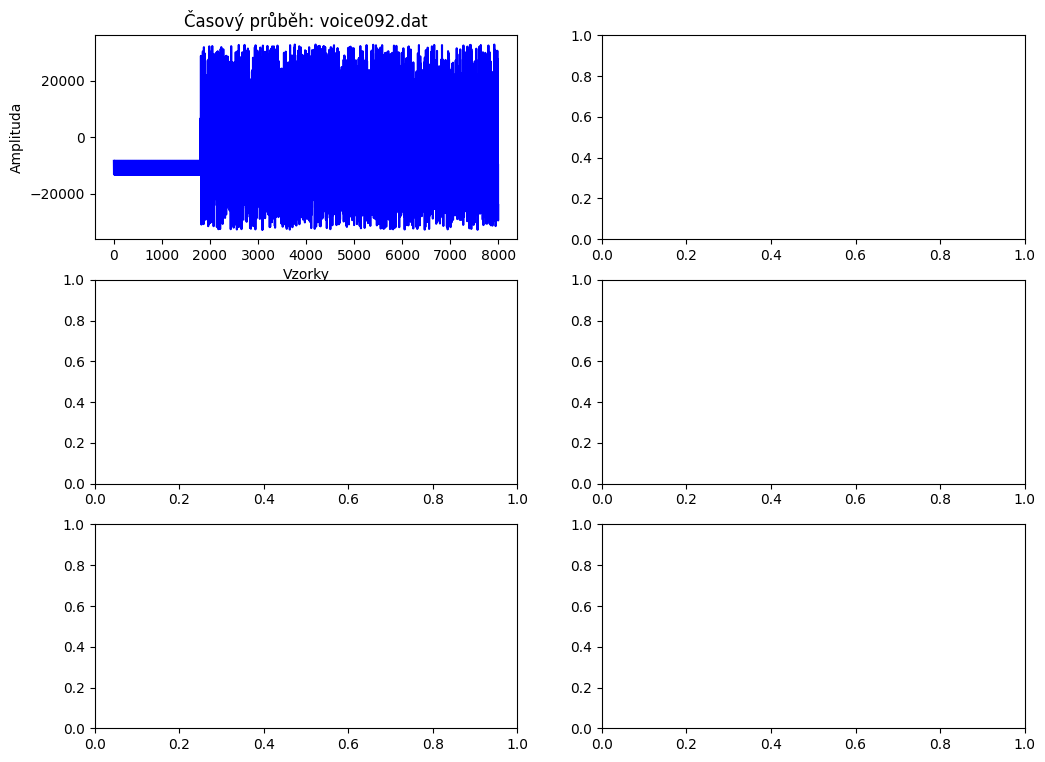

In [17]:
# Vybereme první tři řádky pro vizualizaci
samples_to_plot = df.head(3)

fig, axes = plt.subplots(3, 2, figsize=(12, 9))

for i, row in enumerate(samples_to_plot.itertuples(), 0):
    file_path = os.path.join(data_dir, row.Filename)
    signal = np.fromfile(file_path, dtype=np.int16)

    # Časový průběh signálu
    axes[i, 0].plot(signal[:8000], color="blue")
    axes[i, 0].set_title(f"Časový průběh: {row.Filename}")
    axes[i, 0].set_xlabel("Vzorky")
    axes[i, 0].set_ylabel("Amplituda")

    # Spektrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal.astype(float))), ref=np.max)
    img = librosa.display.specshow(
        D, sr=8000, x_axis="time", y_axis="log", ax=axes[i, 1]
    )
    axes[i, 1].set_title(f"Spektrogram: {row.Filename}")
    axes[i, 1].set_xlabel("Čas (s)")

    # Přidání barevné škály ke spektrogramu
    fig.colorbar(img, ax=axes[i, 1], format="%+2.0f dB")

plt.tight_layout()
plt.show()

# **Vizualizace klasifikace**
plt.figure(figsize=(8, 4))
sns.countplot(x="Classification", data=df, palette="coolwarm")
plt.title("Distribuce klasifikace signálů")
plt.xlabel("Klasifikace")
plt.ylabel("Počet signálů")
plt.show()